**데이터셋 불러오기**

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishkumarak/netflix-reviews-playstore-daily-updated")

print("Path to dataset files:", path)

import pandas as pd
import re 
df = pd.read_csv("netflix_reviews.csv")
df.columns
df.shape
print("Shape of the dataset: ",df.shape)
print("Columns in the dataset: ",df.columns)



Path to dataset files: /Users/anem1c/.cache/kagglehub/datasets/ashishkumarak/netflix-reviews-playstore-daily-updated/versions/170
Shape of the dataset:  (117134, 8)
Columns in the dataset:  Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')


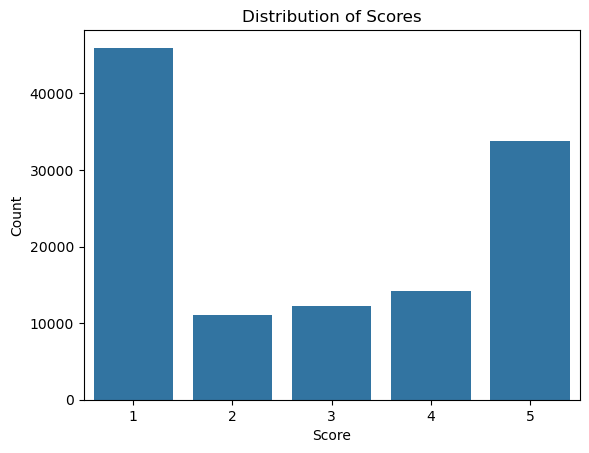

In [7]:

# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    return text
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].apply(preprocess_text)
df.head()
import seaborn as sns  # 그래프를 그리기 위한 seaborn 라이브러리 임포트
import matplotlib.pyplot as plt  # 그래프 표시를 위한 pyplot 임포트

# 리뷰 점수와 리뷰 개수를 계산
score_counts = df['score'].value_counts().reset_index()
score_counts.columns = ['Score', 'Count']

# 막대 그래프 그리기
sns.barplot(x='Score', y='Count', data=score_counts)
plt.xlabel('Score')  # x축 이름
plt.ylabel('Count')  # y축 이름
plt.title('Distribution of Scores')  # 그래프 제목
plt.show()



In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 텍스트 컬럼에 전처리 적용
df['content'] = df['content'].apply(preprocess_text)

# 리뷰와 점수 데이터 추출
reviews = df['content'].values
ratings = df['score'].values

# 레이블 인코딩
label_encoder = LabelEncoder()
ratings = label_encoder.fit_transform(ratings)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=5000)  # 최대 5000개의 단어만 벡터화
reviews_tfidf = vectorizer.fit_transform(reviews).toarray()

# 학습/테스트 데이터 분할
train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(
    reviews_tfidf, ratings, test_size=0.2, random_state=42
)

# 텐서 데이터로 변환
train_reviews_tensor = torch.tensor(train_reviews, dtype=torch.float32)
train_ratings_tensor = torch.tensor(train_ratings, dtype=torch.long)
test_reviews_tensor = torch.tensor(test_reviews, dtype=torch.float32)
test_ratings_tensor = torch.tensor(test_ratings, dtype=torch.long)

# 데이터셋 및 데이터로더 정의
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings):
        self.reviews = reviews
        self.ratings = ratings

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.ratings[idx]

train_dataset = ReviewDataset(train_reviews_tensor, train_ratings_tensor)
test_dataset = ReviewDataset(test_reviews_tensor, test_ratings_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 로지스틱 회귀 모델 정의
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# 하이퍼파라미터 설정
INPUT_DIM = train_reviews_tensor.shape[1]  # TF-IDF 벡터의 차원
OUTPUT_DIM = len(label_encoder.classes_)  # 예측할 점수 개수

# 모델 초기화
model = LogisticRegressionModel(INPUT_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 모델 학습
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch_reviews, batch_ratings in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_reviews)
        loss = criterion(outputs, batch_ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_dataloader)}')

# 예측 함수
def predict_review(model, review):
    model.eval()
    with torch.no_grad():
        review_tfidf = vectorizer.transform([review]).toarray()
        review_tensor = torch.tensor(review_tfidf, dtype=torch.float32)
        output = model(review_tensor)
        prediction = output.argmax(1).item()
        return label_encoder.inverse_transform([prediction])[0]

# 새로운 리뷰에 대한 예측
new_review = "This app is great but has some bugs."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')


/opt/anaconda3/envs/py/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 1/10, Loss: 1.4551051213879633
Epoch 2/10, Loss: 1.408879437381497
Epoch 3/10, Loss: 1.3908150786832738
Epoch 4/10, Loss: 1.3743709767637806
Epoch 5/10, Loss: 1.3592606112411811
Epoch 6/10, Loss: 1.345124237854733
Epoch 7/10, Loss: 1.3320640278350777
Epoch 8/10, Loss: 1.3197930826668853
Epoch 9/10, Loss: 1.3086019070075234
Epoch 10/10, Loss: 1.2978835736525343
Predicted Score: 5
